#### Standard 3D RB Convolutional Autoencoder

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, IterableDataset

import escnn

import numpy as np
import math
import random

import h5py
import os
import sys
sys.path.append('..')

2024-12-20 18:32:26.672625: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 18:32:26.705236: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-20 18:32:27.244853: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(DEVICE))
else:
    print('Failed to find GPU. Will use CPU.')
    DEVICE = 'cpu'

Current device: NVIDIA A100 80GB PCIe


## Data

In [3]:
RB_CHANNELS = 4

BATCH_SIZE = 64

SIMULATION_NAME = '48_48_32_2500_0.7_0.01_0.3_300'

HORIZONTAL_SIZE = int(SIMULATION_NAME.split('_')[0])
HEIGHT = int(SIMULATION_NAME.split('_')[2])

In [4]:
sim_file = os.path.join('..', 'data', 'datasets', f'{SIMULATION_NAME}.h5')

with h5py.File(sim_file, 'r') as hf:
    N_train = hf['train'].shape[0]
    N_valid = hf['valid'].shape[0]
    N_test = hf['test'].shape[0]
    standardization_mean = np.array(hf['mean'])
    standardization_std = np.array(hf['std'])

In [5]:
class DataReader(IterableDataset):
    def __init__(self, filename, dataset, num_samples, shuffle=True):
        super().__init__()
        self.filename = filename
        self.dataset = dataset
        self.shuffle = shuffle
        self.num_samples = num_samples

    def generator(self, start=0, end=None):
        if end == None:
            end = self.num_samples
            
        with h5py.File(self.filename, 'r') as hf:
            snapshots = hf[self.dataset]
            
            indices = list(range(start, end))
            if self.shuffle:
                random.shuffle(indices)

            for i in indices:
                snapshot = snapshots[i]
                h, c, w, d = snapshot.shape
                snapshot = snapshot.reshape(h*c, w, d)
                snapshot = torch.Tensor(snapshot).to(DEVICE)
                yield snapshot, snapshot
                
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = 0
            iter_end = self.num_samples
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.num_samples) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.num_samples)
        return self.generator(iter_start, iter_end)


train_dataset = DataReader(sim_file, 'train', N_train, shuffle=True)
valid_dataset = DataReader(sim_file, 'valid', N_valid, shuffle=True)
test_dataset = DataReader(sim_file, 'test', N_test, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False, drop_last=False)

print('training samples', N_train)
print('validation samples', N_valid)
print('testing samples', N_test)

training samples 24030
validation samples 8010
testing samples 8010


In [6]:
from escnn import nn as enn
from escnn import gspaces
from escnn.gspaces import GSpace
from torch import Tensor

class DataAugmentation:
    def __init__(self, in_height: int, gspace: GSpace = gspaces.flipRot2dOnR2(N=8)):
        self.gspace = gspace
        da_irrep_frequencies = (1, 1) if gspace.flips_order > 0 else (1,) # depending whether using Cn or Dn group  
        self.data_aug_type = enn.FieldType(gspace, 
                                        in_height*[gspace.trivial_repr, 
                                                   gspace.irrep(*da_irrep_frequencies), 
                                                   gspace.trivial_repr])
        
    def __call__(self, *inputs: list[Tensor]) -> Tensor:
        if len(inputs) == 0: return None
        
        transformation = self.gspace.fibergroup.sample()
        
        transformed_inputs = []
        for input in inputs:
            input = enn.GeometricTensor(input, self.data_aug_type)
            transformed_input = input.transform(transformation)
            transformed_inputs.append(transformed_input.tensor)
            
        return transformed_inputs[0] if len(inputs) == 1 else transformed_inputs

## Model Definition

In [11]:
from models.steerable_model import RBSteerableAutoEncoder
from models.cnn_model_torch import RBAutoEncoder
from models.cnn3d_model_torch import RB3DAutoEncoder

# model = RBSteerableAutoEncoder(gspace=escnn.gspaces.flipRot2dOnR2(N=4), # or rot2dOnR2, flipRot2DOnR2
#                                rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
#                                encoder_channels=(8, 16, 32, 64))

# model = RBAutoEncoder(rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
#                       encoder_channels=(16, 32, 64, 128))

model = RB3DAutoEncoder(rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
                        encoder_channels=(32, 64, 128, 512))

model.to(DEVICE)

model.summary()

+--------------+------------------------------------+------------+
| Layer        | Output shape [c, transf., w, d, h] | Parameters |
+--------------+------------------------------------+------------+
| Input        |                    [4, 48, 48, 32] |          0 |
| EncoderConv1 |                   [32, 48, 48, 32] |      3,520 |
| Pooling1     |                   [32, 24, 24, 16] |          0 |
| EncoderConv2 |                   [64, 24, 24, 16] |     55,424 |
| Pooling2     |                    [64, 12, 12, 8] |          0 |
| EncoderConv3 |                   [128, 12, 12, 8] |    221,440 |
| Pooling3     |                     [128, 6, 6, 4] |          0 |
| EncoderConv4 |                     [265, 6, 6, 4] |    916,370 |
| Pooling4     |                     [265, 3, 3, 2] |          0 |
|              |                                    |            |
| DecoderConv1 |                     [265, 3, 3, 2] |  1,896,605 |
| Upsampling1  |                     [265, 6, 6, 4] |         

## Training

In [12]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
data_augmentation = DataAugmentation(in_height=model.in_dims[-1], gspace=gspaces.flipRot2dOnR2(N=4))

In [13]:
def train_one_epoch(train_loss_freq=20):
    running_loss = 0.
    last_loss = 0.

    for i, (inputs, _) in enumerate(train_loader):
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        inputs = data_augmentation(inputs)
        predictions = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(predictions, inputs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % train_loss_freq == train_loss_freq-1:
            last_loss = running_loss / train_loss_freq # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
            
    if i+1 < train_loss_freq:
        last_loss = running_loss / i+1 # loss per batch

    return last_loss

In [14]:
from datetime import datetime

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch()


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        # torch.save(model.state_dict(), model_path)

    epoch_number += 1
    
    
# TODO Setup von Alexander Schnelle nehmen
# TODO LR Schedule
# TODO Early stopping

EPOCH 1:
  batch 20 loss: 2.463976722955704
  batch 40 loss: 1.0393109977245332
  batch 60 loss: 0.8688520967960358
  batch 80 loss: 0.7927554309368133
  batch 100 loss: 0.7144461542367935
  batch 120 loss: 0.5745886206626892
  batch 140 loss: 0.48107954263687136
  batch 160 loss: 0.42178217619657515
  batch 180 loss: 0.39850259125232695
  batch 200 loss: 0.36646171361207963
  batch 220 loss: 0.33754790425300596
  batch 240 loss: 0.3228802740573883
  batch 260 loss: 0.3155181989073753
  batch 280 loss: 0.30771815329790114
  batch 300 loss: 0.2982907757163048
  batch 320 loss: 0.2940395772457123
  batch 340 loss: 0.2911375269293785
  batch 360 loss: 0.28793799579143525
LOSS train 0.28793799579143525 valid 0.26484429836273193
EPOCH 2:
  batch 20 loss: 0.28059517294168473
  batch 40 loss: 0.27199421972036364
  batch 60 loss: 0.27077298164367675
  batch 80 loss: 0.26979203522205353
  batch 100 loss: 0.2641238301992416
  batch 120 loss: 0.26078019440174105
  batch 140 loss: 0.25698795765638

KeyboardInterrupt: 

## Evaluation

### Equivariance

In [11]:
model.check_equivariance(gpu_device=DEVICE, atol=1e-3)

(+, 0[2pi/4]) 0.0 0.0 0.0
(+, 1[2pi/4]) 0.00037136674 3.8325714e-05 9.636841e-10
(+, 2[2pi/4]) 0.0004336834 3.9474577e-05 1.0157963e-09
(+, 3[2pi/4]) 0.00032150745 3.9536335e-05 1.0296585e-09
(-, 0[2pi/4]) 0.00027358532 3.712343e-05 8.6242596e-10
(-, 1[2pi/4]) 0.00030732155 3.9159786e-05 1.0127857e-09
(-, 2[2pi/4]) 0.00039339066 3.8007314e-05 9.736154e-10
(-, 3[2pi/4]) 0.000333488 3.7096048e-05 9.375495e-10


[((+, 0[2pi/4]), 0.0),
 ((+, 1[2pi/4]), 3.8325714e-05),
 ((+, 2[2pi/4]), 3.9474577e-05),
 ((+, 3[2pi/4]), 3.9536335e-05),
 ((-, 0[2pi/4]), 3.712343e-05),
 ((-, 1[2pi/4]), 3.9159786e-05),
 ((-, 2[2pi/4]), 3.8007314e-05),
 ((-, 3[2pi/4]), 3.7096048e-05)]

### MSE

In [15]:
model.eval()

running_test_loss = 0
with torch.no_grad():
    for i, (inputs, outputs) in enumerate(test_loader):
        predictions = model(inputs)
        test_loss = loss_fn(outputs, predictions)
        running_test_loss += test_loss
        
avg_test_loss = running_test_loss / (i + 1)

print(float(avg_test_loss))

0.12752825021743774


### Snapshots

In [16]:
model.eval()

snapshots = next(iter(test_loader))[0][:20]
decoded = model(snapshots)

snapshots = snapshots.cpu().detach().numpy()
decoded = decoded.cpu().detach().numpy()

snapshots = snapshots.reshape(20, HEIGHT, RB_CHANNELS, HORIZONTAL_SIZE, HORIZONTAL_SIZE)
decoded = decoded.reshape(20, HEIGHT, RB_CHANNELS, HORIZONTAL_SIZE, HORIZONTAL_SIZE)

snapshots = snapshots*standardization_std+standardization_mean
decoded = decoded*standardization_std+standardization_mean

snapshots = snapshots.transpose(0, 3, 4, 1, 2) # -> n, w, d, h, c
decoded = decoded.transpose(0, 3, 4, 1, 2) # -> n, w, d, h, c

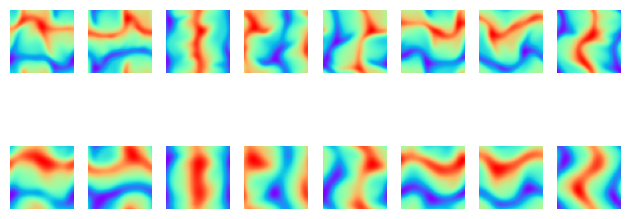

In [17]:
from matplotlib import pyplot as plt

for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(snapshots[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()

    plt.subplot(2, 8, 8+i+1)
    plt.imshow(decoded[i, :, :, 16, 0], cmap='rainbow')
    plt.axis('off')
    plt.tight_layout()
plt.show()

### Animation

In [18]:
# use raw simulation data for animation since train/valid/test datasets are shuffled
def get_sim_data():
    sim_file = h5py.File(os.path.join('..', 'data', 'datasets', f'{SIMULATION_NAME}.h5'), 'r')
    return sim_file, sim_file['test']


def predict_batch(sim_data, i, size):
    """Calculates the models output of a batch of raw simulation data."""
    # prepare input
    inputs = sim_data[i*size:(i+1)*size, :, :, :, :]
    
    b, h, c, w, d = inputs.shape
    inputs = inputs.reshape(b, h*c, w, d)
    inputs = torch.Tensor(inputs).to(DEVICE)
    
    # predict
    model.eval()
    pred = model(inputs)
    
    inputs = inputs.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    
    inputs = inputs.reshape(b, h, c, w, d)
    pred = pred.reshape(b, h, c, w, d)
    
    # remove standardization
    inputs = inputs*standardization_std + standardization_mean
    pred = pred*standardization_std + standardization_mean
    
    inputs = inputs.transpose(0, 3, 4, 1, 2) # -> n, w, d, h, c
    pred = pred.transpose(0, 3, 4, 1, 2) # -> n, w, d, h, c
    
    return inputs, pred

In [19]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def auto_encoder_animation(axis, animation_name, slice, fps, batch_size=32):
    """Animates the output of a AE next to the input across a 2D slice.

    Args:
        axis: 0, 1, 2 for slices across the width, depth or height axis respectively
    """
    sim_file, sim_data = get_sim_data()
    
    batch_x, batch_y = predict_batch(sim_data, 0, batch_size)
    current_batch_nr = 0

    # prepare plot
    if axis == 2:
        # is square when looking from above
        img_extent = [0, 2*np.pi, 0, 2*np.pi]
    else:
        img_extent = [0, 2*np.pi, 0, 2]
    fig = plt.figure()
    ax = plt.subplot(1,2,1)
    orig_im = plt.imshow(np.rot90(batch_x[0, :, :, :, 0].take(indices=slice, axis=axis)), cmap='rainbow', extent=img_extent)
    plt.axis('off')
    ax.set_title('input')

    ax = plt.subplot(1,2,2)
    pred_im = plt.imshow(np.rot90(batch_y[0, :, :, :, 0].take(indices=slice, axis=axis)), cmap='rainbow', extent=img_extent)
    plt.axis('off')
    ax.set_title('output')
    
    def frame_updater(frame):
        """Computes the next frame of the animation."""
        nonlocal batch_x, batch_y, current_batch_nr
        
        required_batch_nr, in_batch_frame = frame//batch_size, frame%batch_size
        if required_batch_nr > current_batch_nr:
            # required to predict next batch
            current_batch_nr = required_batch_nr
            batch_x, batch_y = predict_batch(sim_data, required_batch_nr, batch_size)
        
        # update frames
        orig_data = np.rot90(batch_x[in_batch_frame, :, :, :, 0].take(indices=slice, axis=axis))
        pred_data = np.rot90(batch_y[in_batch_frame, :, :, :, 0].take(indices=slice, axis=axis))
        orig_im.set_array(orig_data)
        pred_im.set_array(pred_data)
        
        # update color map limits
        vmin = min(np.min(orig_data), np.min(pred_data))
        vmax = max(np.max(orig_data), np.max(pred_data))
        orig_im.set_clim(vmin=vmin, vmax=vmax)
        pred_im.set_clim(vmin=vmin, vmax=vmax)
        
        return orig_im, pred_im
    
    anim = animation.FuncAnimation(fig, frame_updater, frames=sim_data.shape[0], interval=1000/fps, blit=True)
    anim.save(f'{animation_name}.mp4')
    
    sim_file.close()

**Width slice**

In [ ]:
auto_encoder_animation(axis=0, animation_name='animations/width', slice=24, fps=30)

from IPython.display import Video
Video("animations/width.mp4")

**Depth slice**

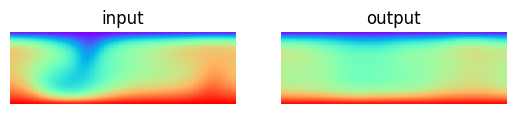

In [ ]:
auto_encoder_animation(axis=1, animation_name='animations/depth', slice=24, fps=30)

from IPython.display import Video
Video("animations/depth.mp4")

**Height slice**

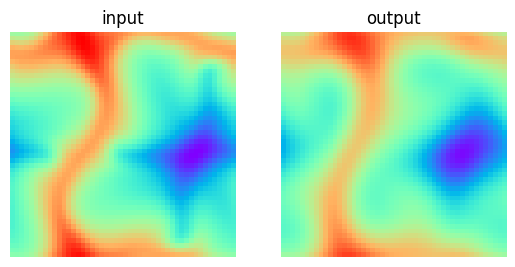

In [18]:
auto_encoder_animation(axis=2, animation_name='animations/height', slice=16, fps=30)

from IPython.display import Video
Video("animations/height.mp4")